## Machine Learning Model Building Pipeline: Data Analysis


===================================================================================================

## Predicting Client Arrears

The aim of the project is to build a machine learning model to predict the Clients Arrears based on different explanatory variables describing aspects of profile and bureaus. 

### Why is this important? 

Predicting client arrears is useful to identify trustful clients, or to determine whether the client will have an acceptable rate of miss-payments.

### What is the objective of the machine learning model?

We aim to minimise the difference between the maximum arrear of a client and the arrear estimated by our model. We will evaluate model performance using the mean squared error (mse) and the root squared of the mean squared error (rmse).

### How do I get the dataset?

AWS Account:
S3 Bucket:
S3 Path:
Contact: 
Dataset name:
Dataset date:
Dataset time range:

**Note the following:**
-  You need to have access to the aws console and be able to read Bucket specifyed path.
-  If you save the file to the same directory where you saved this jupyter notebook, then you can run the code as it is written here.

====================================================================================================

## Clients tuca and directSale dataset:  Model building

In the following cells, we will finally build our machine learning model, utilising the engineered data and the pre-selected features. 


### Setting the seed

**Always set the seeds**.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# to build the model
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

# to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load the train and test set with the engineered variables

# we built and saved these datasets in a previous notebook.
# If you haven't done so, go ahead and check the previous notebooks (step 2)
# to find out how to create these datasets

X_train = pd.read_csv('xtrain.csv')
X_test = pd.read_csv('xtest.csv')

X_train.head()

,id_solicitud,key_solicitud,id_credito,maxmora,qty_meses_desde_desembolso,dfi_solicitud_mora,dfi_solicitud_productos,cl_unq_act_act_messolicitud,cl_unq_act_act_trimestresolicitud,active_cch3_months,ide_tramite,id_tramite,ide_cui,cl_unq_act_act_fechasolicitud,cl_unq_act_act_fechasolicitud_date,cl_unq_act_act_monto,cl_unq_act_act_plazo,cl_unq_act_act_agencia,cl_unq_act_act_ptodestino,cl_unq_act_act_flagaprobado,cl_unq_act_act_longlat,cl_unq_act_act_longitud,cl_unq_act_act_latitud,cl_unq_act_act_depnacimiento,cl_unq_act_act_estadocivil,cl_unq_act_act_estadocivilmodificado,cl_unq_act_act_genero,cl_unq_act_act_profesion,cl_unq_act_act_profesionmodificada,cl_unq_act_act_flagpuedeescribir,cl_unq_act_act_flagpuedeleer,cl_unq_act_act_flaghablaespa_ol,cl_unq_act_act_flagpuedefirmar,cl_unq_act_act_flaghablaotroidioma,cl_unq_act_act_nivelacademico,cl_unq_act_act_tiempovivirresidencia,cl_unq_act_act_tipovivienda,cl_unq_act_act_personasdependientes,cl_unq_act_act_tipolocalidad,cl_unq_act_act_topografia,cl_unq_act_act_flagaccesovehicular,cl_unq_act_act_tipoaccesovehicular,cl_unq_act_act_tipoaccesopeatonal,cl_unq_act_act_flagaccesomensajeros,cl_unq_act_act_flagpidenimpuesto,cl_unq_act_act_vivtipoconstruccion,cl_unq_act_act_cantidadniveles,cl_unq_act_act_cantidaddormitorios,cl_unq_act_act_cantidadba_os,cl_unq_act_act_flagtienecocina,cl_unq_act_act_flagtienesala,cl_unq_act_act_flagtienejardin,cl_unq_act_act_flagtienegarage,cl_unq_act_act_flagtienecomedor,cl_unq_act_act_vehiculo,cl_unq_act_act_fuenteingresos,cl_unq_act_act_tiponegocio,cl_unq_act_act_depnegocio,cl_unq_act_act_flagvendealcredito,cl_unq_act_act_negociomontoventasefectivo,cl_unq_act_act_negociototalingresos,cl_unq_act_act_totalbienes,cl_unq_act_act_totalpasivos,cl_unq_act_act_totalgastosfam,cl_unq_act_act_totalingresosfam,cl_unq_act_act_estresventas,cl_unq_act_act_estrescostoventas,cl_unq_act_act_estresgrossprofit,cl_unq_act_act_flagtieneelectricidad,cl_unq_act_act_flagtieneagua,cl_unq_act_act_flagtienetelfijo,cl_unq_act_act_flagtienecelular,cl_unq_act_act_flagtienetvcable,cl_unq_act_act_flagtienerefrigerador,cl_unq_act_act_flagtienelavadora,cl_unq_act_act_flagtienesecadora,cl_unq_act_act_flagtienehorno,cl_unq_act_act_flagtienemicroondas,cl_unq_act_act_flagtienestereo,cl_unq_act_act_fnacimiento_date,cl_unq_act_act_finicionegocio_date,cl_unq_act_act_fnacimiento_date_numberlong,cl_unq_act_act_finicionegocio_date_numberlong,id_mora,fecha_de_cierre_mora,fecha_consulta_date_mora,cl_cnt_12m_act_comcantidadmora1,cl_cnt_24m_act_comcantidadmora1,cl_cnt_12m_act_comcantidadmora2,cl_cnt_24m_act_comcantidadmora2,cl_des_12m_act_commaxdesvmora,cl_des_24m_act_commaxdesvmora,cl_max_12m_act_commaxmora,cl_max_24m_act_commaxmora,cl_max_act_act_commaxmora,cl_cnt_12m_act_ptocantidadmora1,cl_cnt_24m_act_ptocantidadmora1,cl_cnt_12m_act_ptocantidadmora2,cl_cnt_24m_act_ptocantidadmora2,cl_max_12m_act_ptomaxdesvmora,cl_max_24m_act_ptomaxdesvmora,cl_max_12m_act_ptomaxmora,cl_max_24m_act_ptomaxmora,cl_max_act_act_ptomaxmora,cl_cnt_12m_act_tccantidadmora1,cl_cnt_24m_act_tccantidadmora1,cl_cnt_12m_act_tccantidadmora2,cl_cnt_24m_act_tccantidadmora2,cl_des_12m_act_tcmaxdesvmora,cl_des_24m_act_tcmaxdesvmora,cl_max_12m_act_tcmaxmora,cl_max_24m_act_tcmaxmora,cl_unq_act_act_tcmoraact,cl_cnt_12m_act_servcantidadmora1,cl_cnt_12m_act_servcantidadmora2,cl_des_12m_act_servmaxdesvmora,cl_max_12m_act_servmaxmora,cl_max_act_act_servmaxmora,id_productos,fecha_de_cierre_productos,fecha_consulta_date_tu,cl_min_his_act_ptoexptotal,cl_min_his_act_ptoexpvig,cl_cnt_his_act_comcantidadtotal,cl_sum_his_act_commontototal,cl_cnt_act_act_comcantidadvig,cl_sum_act_act_commontovig,cl_sum_act_act_comsaldoenmora,cl_sum_act_act_comsaldovig,cl_cnt_his_act_ptocantidadtotal,cl_sum_his_act_ptomontototal,cl_cnt_act_act_ptocantidadvig,cl_sum_act_act_ptomontovigente,cl_sum_act_act_ptosaldomora,cl_sum_act_act_ptosaldovig,cl_cnt_act_act_servcantidadvig,cl_sum_act_act_servsaldomora,cl_sum_act_act_servsaldovig,cl_cnt_his_act_tccantidadtotal,cl_sum_his_ac

In [3]:
target_var = 'maxmora'
identifier = ['ide_tramite', 'ide_cui', 'id_credito', 'id_solicitud', 'id_tramite','cl_unq_act_act_agencia']

In [4]:
X_train.groupby([target_var])[target_var].count()

maxmora
0    17484
1     6852
2      406
3      109
4       23
Name: maxmora, dtype: int64

In [5]:
# capture the target (remember that is log transformed)

y_train = X_train[target_var]
y_test = X_test[target_var]

In [6]:
# load the pre-selected features
# ==============================

# we selected the features in the previous notebook (step 3) recommended_features.csv

recommended_features = pd.read_csv('recommended_features.csv')
recommended_features = recommended_features['0'].to_list() 

# we manually chose features in notebook (step 2) 

features_numerical = pd.read_csv('selected_numerical_features.csv')
features_numerical = features_numerical['0'].to_list() 
features_categorical = pd.read_csv('selected_categorical_features.csv')
features_categorical = features_categorical['0'].to_list() 
features = features_numerical + features_categorical

# We will add one additional feature to the ones we selected in the
# previous notebook: 'cl_unq_act_act_fnacimiento_date'

# why?
#=====

# here goes justification

features = features + ['cl_unq_act_act_fnacimiento_date', 'cl_unq_act_act_messolicitud', 'qty_meses_desde_desembolso'] 

# display final feature set
print(len(features))
features

25


['cl_unq_act_act_totalgastosfam',
 'cl_unq_act_act_negociototalingresos',
 'cl_unq_act_act_totalbienes',
 'cl_unq_act_act_monto',
 'cl_unq_act_act_ptodestino',
 'cl_unq_act_act_depnacimiento',
 'cl_unq_act_act_estadocivil',
 'cl_unq_act_act_estadocivilmodificado',
 'cl_unq_act_act_genero',
 'cl_unq_act_act_flagpuedeescribir',
 'cl_unq_act_act_flagpuedeleer',
 'cl_unq_act_act_tiempovivirresidencia',
 'cl_unq_act_act_flagaccesovehicular',
 'cl_unq_act_act_tipoaccesovehicular',
 'cl_unq_act_act_flagaccesomensajeros',
 'cl_unq_act_act_flagtienegarage',
 'cl_unq_act_act_flagtienecomedor',
 'cl_unq_act_act_depnegocio',
 'cl_unq_act_act_flagtieneagua',
 'cl_unq_act_act_flagtienerefrigerador',
 'cl_unq_act_act_flagtienelavadora',
 'cl_unq_act_act_flagtienestereo',
 'cl_unq_act_act_fnacimiento_date',
 'cl_unq_act_act_messolicitud',
 'qty_meses_desde_desembolso']

In [7]:
# reduce the train and test set to the selected features

X_train = X_train[features]
X_test = X_test[features]

### Regularised linear regression: Lasso

Remember to set the seed.

In [8]:
# set up the model
# remember to set the random_state / seed

lin_model = Lasso(alpha=0.005, random_state=0)

# train the model

lin_model.fit(X_train, y_train)

Lasso(alpha=0.005, random_state=0)

In [9]:
pred = lin_model.predict(X_train)

In [10]:
# evaluate the model:
# ====================

# remember that we log transformed the output (maxmora)
# in our feature engineering notebook (step 2).

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original house prices values.

# We will evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = lin_model.predict(X_train)

# determine mse and rmse
print('train mse: {}'.format((
    mean_squared_error((y_train), (pred)))))
print('train rmse: {}'.format((
    sqrt(mean_squared_error((y_train), (pred))))))
print('train r2: {}'.format(
    r2_score((y_train), (pred))))
print()

# make predictions for test set
pred = lin_model.predict(X_test)

# determine mse and rmse
print('test mse: {}'.format((
    mean_squared_error((y_test), (pred)))))
print('test rmse: {}'.format((
    sqrt(mean_squared_error((y_test), (pred))))))
print('test r2: {}'.format(
    r2_score((y_test), (pred))))
print()

print('Average maxmora: ', int((y_train).median()))

train mse: 0.25411681485365006
train rmse: 0.5041000048141738
train r2: 0.12189773733864095

test mse: 0.2461452221255973
test rmse: 0.4961302471383873
test r2: 0.11251981276438949

Average maxmora:  0


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

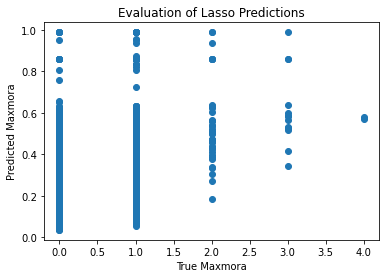

In [11]:
# let's evaluate our predictions respect to the real maxmora
plt.scatter(y_test, lin_model.predict(X_test))
plt.xlabel('True Maxmora')
plt.ylabel('Predicted Maxmora')
plt.title('Evaluation of Lasso Predictions')

We can see that our model is doing a pretty good/bad job at estimating maxmora.

<AxesSubplot:>

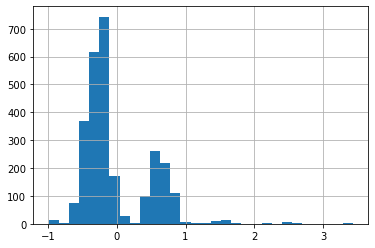

In [12]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test - lin_model.predict(X_test)
errors.hist(bins=30)

The distribution of the errors follows quite closely a gaussian distribution. That suggests that our model is doing a good job as well.

### Feature importance

Text(0.5, 1.0, 'Feature Importance')

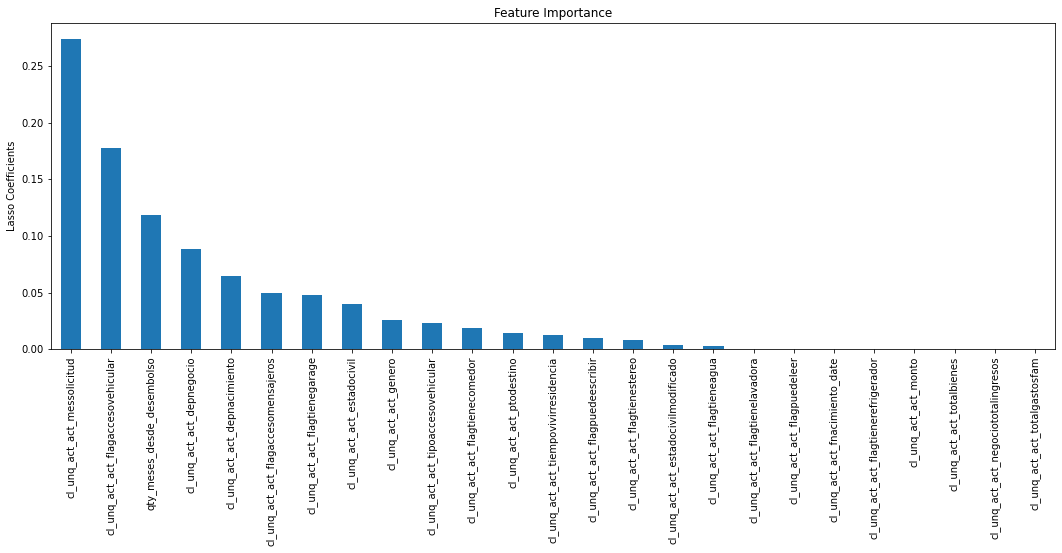

In [13]:
# Finally, just for fun, let's look at the feature importance

importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = features
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

And that is all! Now we have our entire pipeline ready for deployment. 

In the next video, we will summarise which steps from the pipeline we will deploy to production.

### Regularised linear regression: RandomForest
Remember to set the seed.

In [14]:
# set up the model
# remember to set the random_state / seed

clf = RandomForestClassifier(max_depth=2, random_state=0)

# train the model

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [15]:
# evaluate the model:
# ====================

# remember that we log transformed the output (maxmora)
# in our feature engineering notebook (step 2).

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original house prices values.

# We will evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = clf.predict(X_train)

# determine mse and rmse
print('train mse: {}'.format((
    mean_squared_error((y_train), (pred)))))
print('train rmse: {}'.format((
    sqrt(mean_squared_error((y_train), (pred))))))
print('train r2: {}'.format(
    r2_score((y_train), (pred))))
print()

# make predictions for test set
pred = clf.predict(X_test)

# determine mse and rmse
print('test mse: {}'.format((
    mean_squared_error((y_test), (pred)))))
print('test rmse: {}'.format((
    sqrt(mean_squared_error((y_test), (pred))))))
print('test r2: {}'.format(
    r2_score((y_test), (pred))))
print()

print('Average maxmora: ', ((y_train).median()))

train mse: 0.36978370989788534
train rmse: 0.6080984376709788
train r2: -0.2777899508289099

test mse: 0.3505788712011577
test rmse: 0.5920970116468733
test r2: -0.2640172316474838

Average maxmora:  0.0


In [37]:
pred = clf.predict(X_train)
pred.sum()

507

In [38]:
pred = clf.predict(X_test)
pred.sum()

63

Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

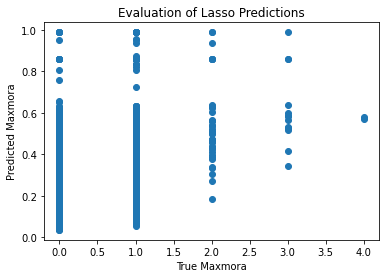

In [18]:
# let's evaluate our predictions respect to the real maxmora
plt.scatter(y_test, lin_model.predict(X_test))
plt.xlabel('True Maxmora')
plt.ylabel('Predicted Maxmora')
plt.title('Evaluation of Lasso Predictions')

We can see that our model is doing a pretty good/bad job at estimating maxmora.

<AxesSubplot:>

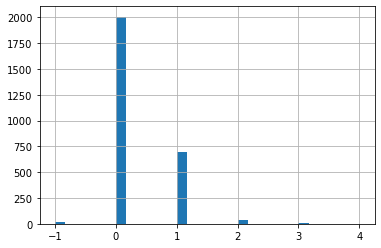

In [19]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test - clf.predict(X_test)
errors.hist(bins=30)

Text(0.5, 1.0, 'Feature Importance')

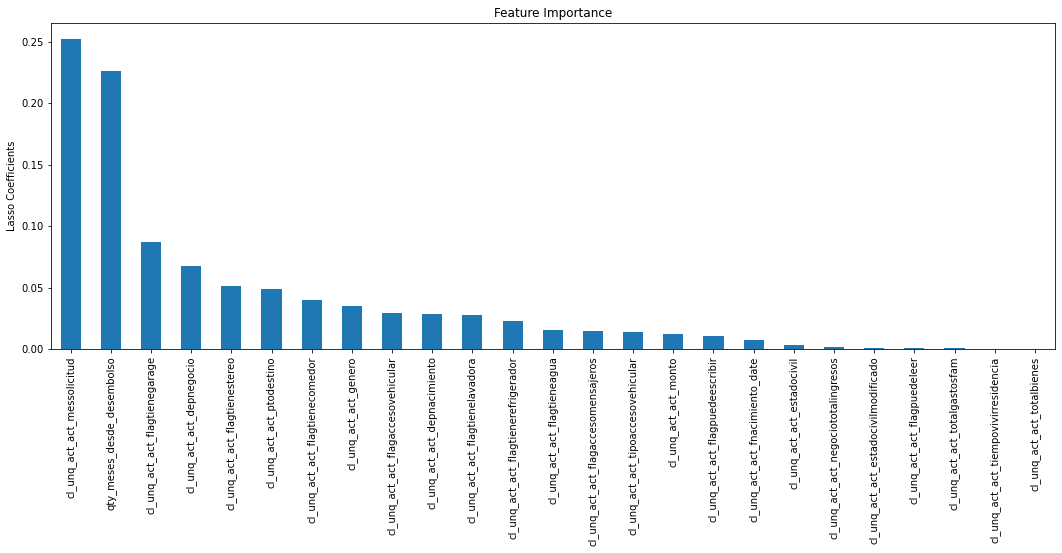

In [20]:
# Finally, just for fun, let's look at the feature importance

importance = pd.Series(np.abs(clf.feature_importances_))
importance.index = features
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

### Validate Inputs
This is for the input inference dataset, clean before preprocessing and feature engineering.

In [57]:
X_test = pd.read_csv('datasettest.csv')

In [58]:
NA_NOT_ALLOWED = [
    'cl_unq_act_act_ptodestino',
    'cl_unq_act_act_flagpuedeescribir',
    'cl_unq_act_act_flagpuedeleer',
    'cl_unq_act_act_flagaccesovehicular',
    'cl_unq_act_act_flagaccesomensajeros',
    'cl_unq_act_act_flagtienegarage',
    'cl_unq_act_act_flagtienecomedor',
    'cl_unq_act_act_flagtieneagua',
    'cl_unq_act_act_flagtienerefrigerador',
    'cl_unq_act_act_flagtienelavadora',
    'cl_unq_act_act_flagtienestereo',
    'qty_meses_desde_desembolso',
    'cl_unq_act_act_messolicitud',
    #'cl_unq_act_act_fechasolicitud',
    'cl_unq_act_act_fnacimiento_date'
]
NUMERICALS_LOG_VARS = [
    "cl_unq_act_act_totalgastosfam",
    "cl_unq_act_act_negociototalingresos",
    "cl_unq_act_act_totalbienes",
    "cl_unq_act_act_monto"
]

In [59]:
from itertools import compress
print(X_test.shape)

# remove na from list where NA is not allowed
if X_test[NA_NOT_ALLOWED].isnull().any().any():
        X_test = X_test.dropna(
            axis=0, subset=NA_NOT_ALLOWED
        )
print(X_test.shape)

# remove negative and zero values from LOG_VARS
vars_with_neg_values = list(compress(
                            NUMERICALS_LOG_VARS, 
                            (X_test[NUMERICALS_LOG_VARS] == 0).any().tolist())
                           )
ver = ~(X_test[NUMERICALS_LOG_VARS] < 0).any(axis = 1)
X_test = X_test.loc[ver]
print(X_test.shape)

(2764, 151)
(2421, 151)
(2421, 151)


In [60]:
X_test.shape

(2421, 151)